In [1]:
#### Import libraries

import torch
from rdkit import DataStructs
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import AllChem, rdMolDescriptors
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from tqdm import tqdm
import copy
import numpy as np
import matplotlib.pyplot as plt

Processing molecules and generating features...


100%|██████████| 33208/33208 [02:06<00:00, 262.08it/s]
c:\Users\shadr\OneDrive - UGent\Shadrach_Backup\Antimalaria_Machine_Learning\Anti-Malarial-Activity-Prediction-Project\.venv\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 01 - Train Loss: 0.6936 - Test ROC AUC: 0.4699 - Test PR AUC: 0.4947
Epoch 02 - Train Loss: 0.6931 - Test ROC AUC: 0.5005 - Test PR AUC: 0.4988
Epoch 03 - Train Loss: 0.6930 - Test ROC AUC: 0.5059 - Test PR AUC: 0.5077
Epoch 04 - Train Loss: 0.6929 - Test ROC AUC: 0.5025 - Test PR AUC: 0.5036
Epoch 05 - Train Loss: 0.6926 - Test ROC AUC: 0.4988 - Test PR AUC: 0.5068
Epoch 06 - Train Loss: 0.6927 - Test ROC AUC: 0.5028 - Test PR AUC: 0.5036
Epoch 07 - Train Loss: 0.6928 - Test ROC AUC: 0.5029 - Test PR AUC: 0.5051
Epoch 08 - Train Loss: 0.6924 - Test ROC AUC: 0.5016 - Test PR AUC: 0.4975
Epoch 09 - Train Loss: 0.6902 - Test ROC AUC: 0.5685 - Test PR AUC: 0.5775
Epoch 10 - Train Loss: 0.6851 - Test ROC AUC: 0.5866 - Test PR AUC: 0.5974
Epoch 11 - Train Loss: 0.6789 - Test ROC AUC: 0.5902 - Test PR AUC: 0.6015
Epoch 12 - Train Loss: 0.6734 - Test ROC AUC: 0.5961 - Test PR AUC: 0.6055
Epoch 13 - Train Loss: 0.6721 - Test ROC AUC: 0.5825 - Test PR AUC: 0.5963
Epoch 14 - Train Loss: 0.

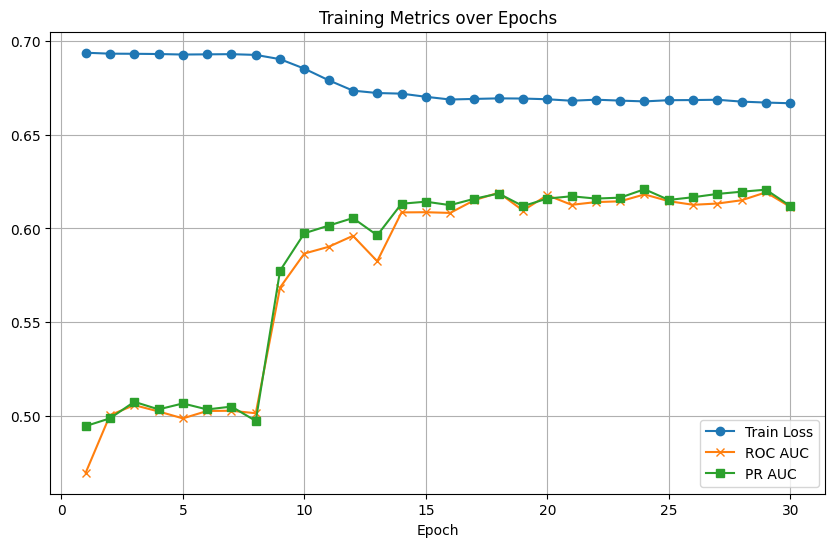

In [2]:



# ---------------------------
# 1. Data Preparation
# ---------------------------

def mol_to_graph_data_obj(mol):
    """Convert RDKit mol object to PyTorch Geometric Data object"""
    # Node features: atomic number one-hot encoding (simplified here as atomic number)
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append([atom.GetAtomicNum()])
    x = torch.tensor(atom_features, dtype=torch.float)

    # Edges
    edge_index = []
    edge_attr = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append([i, j])
        edge_index.append([j, i])
        # Bond type as edge feature (single=1, double=2, triple=3, aromatic=4)
        bond_type = bond.GetBondType()
        if bond_type == Chem.rdchem.BondType.SINGLE:
            bt = 1
        elif bond_type == Chem.rdchem.BondType.DOUBLE:
            bt = 2
        elif bond_type == Chem.rdchem.BondType.TRIPLE:
            bt = 3
        elif bond_type == Chem.rdchem.BondType.AROMATIC:
            bt = 4
        else:
            bt = 0
        edge_attr.append([bt])
        edge_attr.append([bt])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data

def get_rdkit_fingerprint(mol, fp_size=2048):
    """Generate RDKit Daylight-like fingerprint as numpy array"""
    fp = Chem.RDKFingerprint(mol, fpSize=fp_size)
    arr = np.zeros((fp_size,), dtype=int)
    on_bits = list(fp.GetOnBits())
    arr[on_bits] = 1
    return arr

# Load your dataset CSV with 'canonical_smiles' and 'label' columns
df = pd.read_csv('../data/merged_dataset.csv')

# Filter valid molecules
valid_rows = []
graph_data_list = []
fingerprints = []
labels = []

print("Processing molecules and generating features...")
for idx, row in tqdm(df.iterrows(), total=len(df)):
    smi = row['canonical_smiles']
    label = row['activity_label']  # assuming binary label: 0 or 1
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        continue
    # Graph data
    graph_data = mol_to_graph_data_obj(mol)
    graph_data.y = torch.tensor([label], dtype=torch.float)
    graph_data_list.append(graph_data)

    # Fingerprint
    fp = get_rdkit_fingerprint(mol)
    fingerprints.append(fp)

    labels.append(label)
    valid_rows.append(idx)

# Convert fingerprints to tensor
fingerprints = torch.tensor(np.array(fingerprints), dtype=torch.float)

# ---------------------------
# 2. Dataset and DataLoader
# ---------------------------

# Split indices for train/test
train_idx, test_idx = train_test_split(range(len(graph_data_list)), test_size=0.2, stratify=labels, random_state=42)

train_graphs = [graph_data_list[i] for i in train_idx]
test_graphs = [graph_data_list[i] for i in test_idx]

train_fps = fingerprints[train_idx]
test_fps = fingerprints[test_idx]

train_labels = torch.tensor([labels[i] for i in train_idx], dtype=torch.float)
test_labels = torch.tensor([labels[i] for i in test_idx], dtype=torch.float)

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

# ---------------------------
# 3. FP-GNN Model Definition
# ---------------------------

class FP_GNN(nn.Module):
    def __init__(self, fp_dim=2048, gnn_hidden_dim=128, fp_hidden_dim=128, out_dim=1):
        super(FP_GNN, self).__init__()
        # GNN layers (Graph Attention Network)
        self.conv1 = GATConv(in_channels=1, out_channels=gnn_hidden_dim, heads=4, concat=True)
        self.conv2 = GATConv(in_channels=gnn_hidden_dim*4, out_channels=gnn_hidden_dim, heads=4, concat=False)
        
        # Fingerprint MLP
        self.fp_mlp = nn.Sequential(
            nn.Linear(fp_dim, fp_hidden_dim),
            nn.ReLU(),
            nn.Linear(fp_hidden_dim, fp_hidden_dim),
            nn.ReLU()
        )
        
        # Combined MLP
        self.combined_mlp = nn.Sequential(
            nn.Linear(gnn_hidden_dim + fp_hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, out_dim)
        )
        
    def forward(self, data, fp):
        # data: PyG batch object with x, edge_index, edge_attr, batch
        x, edge_index = data.x, data.edge_index
        
        # GNN forward
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        
        # Global pooling (mean)
        x = global_mean_pool(x, data.batch)
        
        # Fingerprint forward
        fp_emb = self.fp_mlp(fp)
        
        # Concatenate graph and fingerprint embeddings
        combined = torch.cat([x, fp_emb], dim=1)
        
        out = self.combined_mlp(combined)
        return out.squeeze(1)  # output shape: (batch_size,)

# ---------------------------
# 4. Training and Evaluation Functions
# ---------------------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FP_GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

def train_epoch(model, loader, fps, optimizer, criterion):
    model.train()
    total_loss = 0
    for i, batch in enumerate(loader):
        batch = batch.to(device)
        batch_fp = fps[i*loader.batch_size : i*loader.batch_size + batch.num_graphs].to(device)
        optimizer.zero_grad()
        out = model(batch, batch_fp)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, fps, labels):
    model.eval()
    preds = []
    trues = []
    for i, batch in enumerate(loader):
        batch = batch.to(device)
        batch_fp = fps[i*loader.batch_size : i*loader.batch_size + batch.num_graphs].to(device)
        out = model(batch, batch_fp)
        preds.append(torch.sigmoid(out).cpu())
        trues.append(batch.y.cpu())
    preds = torch.cat(preds).numpy()
    trues = torch.cat(trues).numpy()
    roc_auc = roc_auc_score(trues, preds)
    pr_auc = average_precision_score(trues, preds)
    return roc_auc, pr_auc

# ---------------------------
# 5. Run Training and Evaluation
# ---------------------------
train_losses = []
roc_aucs = []
pr_aucs = []

num_epochs = 30

for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch(model, train_loader, train_fps, optimizer, criterion)
    train_losses.append(train_loss)
    roc_auc, pr_auc = evaluate(model, test_loader, test_fps, test_labels)
    roc_aucs.append(roc_auc)
    pr_aucs.append(pr_auc)
    print(f"Epoch {epoch:02d} - Train Loss: {train_loss:.4f} - Test ROC AUC: {roc_auc:.4f} - Test PR AUC: {pr_auc:.4f}")



 ##Plotting all metrics
plt.figure(figsize=(10,6))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, num_epochs + 1), roc_aucs, marker='x', label='ROC AUC')
plt.plot(range(1, num_epochs + 1), pr_aucs, marker='s', label='PR AUC')
plt.title('Training Metrics over Epochs')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend()
plt.show()


Processing molecules and generating features...


100%|██████████| 33208/33208 [00:24<00:00, 1329.18it/s]
c:\Users\shadr\OneDrive - UGent\Shadrach_Backup\Antimalaria_Machine_Learning\Anti-Malarial-Activity-Prediction-Project\.venv\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 01 - Train Loss: 0.6934 - Test ROC AUC: 0.4468 - Test PR AUC: 0.4654
Epoch 02 - Train Loss: 0.6932 - Test ROC AUC: 0.5012 - Test PR AUC: 0.5398
Epoch 03 - Train Loss: 0.6932 - Test ROC AUC: 0.5430 - Test PR AUC: 0.5626
Epoch 04 - Train Loss: 0.6929 - Test ROC AUC: 0.5099 - Test PR AUC: 0.5365
Epoch 05 - Train Loss: 0.6924 - Test ROC AUC: 0.5239 - Test PR AUC: 0.5301
Epoch 06 - Train Loss: 0.6920 - Test ROC AUC: 0.5155 - Test PR AUC: 0.5282
Epoch 07 - Train Loss: 0.6904 - Test ROC AUC: 0.5766 - Test PR AUC: 0.5966
Epoch 08 - Train Loss: 0.6885 - Test ROC AUC: 0.5757 - Test PR AUC: 0.5930
Epoch 09 - Train Loss: 0.6850 - Test ROC AUC: 0.5970 - Test PR AUC: 0.6001
Epoch 10 - Train Loss: 0.6811 - Test ROC AUC: 0.5963 - Test PR AUC: 0.6001
Epoch 11 - Train Loss: 0.6793 - Test ROC AUC: 0.6044 - Test PR AUC: 0.6080
Epoch 12 - Train Loss: 0.6782 - Test ROC AUC: 0.6034 - Test PR AUC: 0.6055
Epoch 13 - Train Loss: 0.6763 - Test ROC AUC: 0.6031 - Test PR AUC: 0.6032
Epoch 14 - Train Loss: 0.

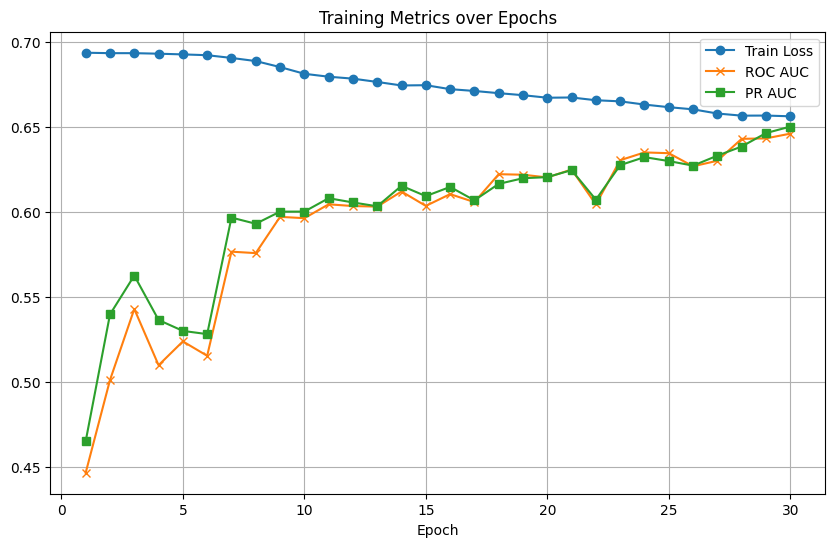

In [11]:

# Morgan fingerprint instead of RDKit fingerprint


# ---------------------------
# 1. Data Preparation
# ---------------------------

def mol_to_graph_data_obj(mol):
    """Convert RDKit mol object to PyTorch Geometric Data object"""
    # Node features: atomic number one-hot encoding (simplified here as atomic number)
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append([atom.GetAtomicNum()])
    x = torch.tensor(atom_features, dtype=torch.float)

    # Edges
    edge_index = []
    edge_attr = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append([i, j])
        edge_index.append([j, i])
        # Bond type as edge feature (single=1, double=2, triple=3, aromatic=4)
        bond_type = bond.GetBondType()
        if bond_type == Chem.rdchem.BondType.SINGLE:
            bt = 1
        elif bond_type == Chem.rdchem.BondType.DOUBLE:
            bt = 2
        elif bond_type == Chem.rdchem.BondType.TRIPLE:
            bt = 3
        elif bond_type == Chem.rdchem.BondType.AROMATIC:
            bt = 4
        else:
            bt = 0
        edge_attr.append([bt])
        edge_attr.append([bt])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data


def get_morgan_generator_fingerprint(mol, radius=2, n_bits=2048):
    """
    Generate Morgan fingerprint using the recommended MorganGenerator.
    Args:
        mol (rdkit.Chem.Mol): RDKit molecule object.
        radius (int): Radius for Morgan fingerprint.
        n_bits (int): Length of fingerprint vector.
    Returns:
        np.ndarray: Binary fingerprint vector.
    """
   
    # Create Morgan fingerprint generator with correct parameters
    morgan_gen = rdFingerprintGenerator.GetMorganGenerator(
        radius=radius,
        countSimulation=False,
        includeChirality=False,
        useBondTypes=True,
        onlyNonzeroInvariants=False,
        includeRedundantEnvironments=False,
        fpSize=n_bits
    )

    # Generate fingerprint bit vector
    bit_info = {}
    fp = morgan_gen.GetFingerprint(mol)
    
    # Convert to numpy array
    arr = np.zeros((n_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr


#def get_morgan_fingerprint(mol, radius=2, n_bits=2048): ## this is already deprecated
    """
    Generate Morgan fingerprint as numpy array.
    Args:
        mol (rdkit.Chem.Mol): RDKit molecule object.
        radius (int): Radius parameter for Morgan fingerprint.
        n_bits (int): Length of the fingerprint vector.
    Returns:
        np.ndarray: Binary fingerprint vector.
    """
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

#def get_rdkit_fingerprint(mol, fp_size=2048):
    """Generate RDKit Daylight-like fingerprint as numpy array"""
    fp = Chem.RDKFingerprint(mol, fpSize=fp_size)
    arr = np.zeros((fp_size,), dtype=int)
    on_bits = list(fp.GetOnBits())
    arr[on_bits] = 1
    return arr

# Load your dataset CSV with 'canonical_smiles' and 'label' columns
df = pd.read_csv('../data/merged_dataset.csv')

# Filter valid molecules
valid_rows = []
graph_data_list = []
fingerprints = []
labels = []

print("Processing molecules and generating features...")
for idx, row in tqdm(df.iterrows(), total=len(df)):
    smi = row['canonical_smiles']
    label = row['activity_label']  # assuming binary label: 0 or 1
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        continue
    # Graph data
    graph_data = mol_to_graph_data_obj(mol)
    graph_data.y = torch.tensor([label], dtype=torch.float)
    graph_data_list.append(graph_data)

    # Fingerprint
    #fp = get_rdkit_fingerprint(mol)
    #fingerprints.append(fp)
    # Morgan fingerprint instead of RDKit fingerprint
    fp = get_morgan_generator_fingerprint(mol)
    fingerprints.append(fp)

    labels.append(label)
    valid_rows.append(idx)

# Convert fingerprints to tensor
fingerprints = torch.tensor(np.array(fingerprints), dtype=torch.float)

# ---------------------------
# 2. Dataset and DataLoader
# ---------------------------

# Split indices for train/test
train_idx, test_idx = train_test_split(range(len(graph_data_list)), test_size=0.2, stratify=labels, random_state=42)

train_graphs = [graph_data_list[i] for i in train_idx]
test_graphs = [graph_data_list[i] for i in test_idx]

train_fps = fingerprints[train_idx]
test_fps = fingerprints[test_idx]

train_labels = torch.tensor([labels[i] for i in train_idx], dtype=torch.float)
test_labels = torch.tensor([labels[i] for i in test_idx], dtype=torch.float)

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

# ---------------------------
# 3. FP-GNN Model Definition
# ---------------------------

class FP_GNN(nn.Module):
    def __init__(self, fp_dim=2048, gnn_hidden_dim=128, fp_hidden_dim=128, out_dim=1):
        super(FP_GNN, self).__init__()
        # GNN layers (Graph Attention Network)
        self.conv1 = GATConv(in_channels=1, out_channels=gnn_hidden_dim, heads=4, concat=True)
        self.conv2 = GATConv(in_channels=gnn_hidden_dim*4, out_channels=gnn_hidden_dim, heads=4, concat=False)
        
        # Fingerprint MLP
        self.fp_mlp = nn.Sequential(
            nn.Linear(fp_dim, fp_hidden_dim),
            nn.ReLU(),
            nn.Linear(fp_hidden_dim, fp_hidden_dim),
            nn.ReLU()
        )
        
        # Combined MLP
        self.combined_mlp = nn.Sequential(
            nn.Linear(gnn_hidden_dim + fp_hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, out_dim)
        )
        
    def forward(self, data, fp):
        # data: PyG batch object with x, edge_index, edge_attr, batch
        x, edge_index = data.x, data.edge_index
        
        # GNN forward
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        
        # Global pooling (mean)
        x = global_mean_pool(x, data.batch)
        
        # Fingerprint forward
        fp_emb = self.fp_mlp(fp)
        
        # Concatenate graph and fingerprint embeddings
        combined = torch.cat([x, fp_emb], dim=1)
        
        out = self.combined_mlp(combined)
        return out.squeeze(1)  # output shape: (batch_size,)

# ---------------------------
# 4. Training and Evaluation Functions
# ---------------------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FP_GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

def train_epoch(model, loader, fps, optimizer, criterion):
    model.train()
    total_loss = 0
    for i, batch in enumerate(loader):
        batch = batch.to(device)
        batch_fp = fps[i*loader.batch_size : i*loader.batch_size + batch.num_graphs].to(device)
        optimizer.zero_grad()
        out = model(batch, batch_fp)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, fps, labels):
    model.eval()
    preds = []
    trues = []
    for i, batch in enumerate(loader):
        batch = batch.to(device)
        batch_fp = fps[i*loader.batch_size : i*loader.batch_size + batch.num_graphs].to(device)
        out = model(batch, batch_fp)
        preds.append(torch.sigmoid(out).cpu())
        trues.append(batch.y.cpu())
    preds = torch.cat(preds).numpy()
    trues = torch.cat(trues).numpy()
    roc_auc = roc_auc_score(trues, preds)
    pr_auc = average_precision_score(trues, preds)
    return roc_auc, pr_auc

# ---------------------------
# 5. Run Training and Evaluation
# ---------------------------
train_losses = []
roc_aucs = []
pr_aucs = []

num_epochs = 30

for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch(model, train_loader, train_fps, optimizer, criterion)
    train_losses.append(train_loss)
    roc_auc, pr_auc = evaluate(model, test_loader, test_fps, test_labels)
    roc_aucs.append(roc_auc)
    pr_aucs.append(pr_auc)
    print(f"Epoch {epoch:02d} - Train Loss: {train_loss:.4f} - Test ROC AUC: {roc_auc:.4f} - Test PR AUC: {pr_auc:.4f}")



 ##Plotting all metrics
plt.figure(figsize=(10,6))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, num_epochs + 1), roc_aucs, marker='x', label='ROC AUC')
plt.plot(range(1, num_epochs + 1), pr_aucs, marker='s', label='PR AUC')
plt.title('Training Metrics over Epochs')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend()
plt.show()
